# Examining the difference between drifting and static gratings

Overview: In this notebook we investigate the difference in spike count and variability between static and drifting gratings. We formalise this with hypothesis tests. Our findings were that spike_mean tends to be higher when units are presented with drifting gratings than static gratings whereas the variability is higher for static gratings. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "./allendata"

manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()

In [3]:
id = 750332458
session = cache.get_session_data(id)

c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\georg\anaconda3\Anaconda1\envs\neuroscience_project\Lib\site-packages\hdmf\spec\namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Getting the table for static and drifting

In [4]:
table_static = session.get_stimulus_table("static_gratings")

table_static.head()

,stimulus_block,start_time,stop_time,orientation,spatial_frequency,size,phase,contrast,stimulus_name,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,
49434,8.0,5398.833208,5399.083416,0.0,0.04,"[250.0, 250.0]",0.25,0.8,static_gratings,0.250209,4787
49435,8.0,5399.083416,5399.333625,0.0,0.32,"[250.0, 250.0]",0.0,0.8,static_gratings,0.250209,4788
49436,8.0,5399.333625,5399.583834,30.0,0.04,"[250.0, 250.0]",0.0,0.8,static_gratings,0.250209,4789
49437,8.0,5399.583834,5399.834042,90.0,0.08,"[250.0, 250.0]",0.75,0.8,static_gratings,0.250209,4790
49438,8.0,5399.834042,5400.084249,60.0,0.08,"[250.0, 250.0]",0.25,0.8,static_gratings,0.250206,4791


In [5]:
table_drifting = session.get_stimulus_table("drifting_gratings")

table_drifting.head()

,stimulus_block,start_time,stop_time,orientation,temporal_frequency,spatial_frequency,size,phase,contrast,stimulus_name,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,2.0,1585.647748,1587.649398,180.0,4.0,0.04,"[250.0, 250.0]","[21235.93333333, 21235.93333333]",0.8,drifting_gratings,2.00165,246
3799,2.0,1588.650242,1590.651902,225.0,4.0,0.04,"[250.0, 250.0]","[21235.93333333, 21235.93333333]",0.8,drifting_gratings,2.00166,247
3800,2.0,1591.652728,1593.654418,135.0,2.0,0.04,"[250.0, 250.0]","[21235.93333333, 21235.93333333]",0.8,drifting_gratings,2.00169,248
3801,2.0,1594.655252,1596.656912,0.0,2.0,0.04,"[250.0, 250.0]","[21235.93333333, 21235.93333333]",0.8,drifting_gratings,2.00166,249
3802,2.0,1597.657758,1599.659418,315.0,15.0,0.04,"[250.0, 250.0]","[21235.93333333, 21235.93333333]",0.8,drifting_gratings,2.00166,250


### Desigining a spike count function get_spike()

In [6]:
def get_spike(session, stimuli, ecephys_structure_acronym):

    table = session.get_stimulus_table(stimuli)


    stimulus_presentation_ids = table.index.values
    unit_ids = session.units[session.units["ecephys_structure_acronym"] == ecephys_structure_acronym].index.values

    spike_counts = session.conditionwise_spike_statistics(
        stimulus_presentation_ids=stimulus_presentation_ids,
        unit_ids =unit_ids,
    )
 
    return spike_counts

In [7]:
def get_spike(session, stimuli, ecephys_structure_acronym):
    table = session.get_stimulus_table(stimuli)

    # Filter for orientation = 0
    if "orientation" not in table.columns:
        raise ValueError("The stimulus table does not contain an 'orientation' column.")

    filtered_table = table[table["orientation"] == 0]
    stimulus_presentation_ids = filtered_table.index.values

    unit_ids = session.units[session.units["ecephys_structure_acronym"] == ecephys_structure_acronym].index.values

    spike_counts = session.conditionwise_spike_statistics(
        stimulus_presentation_ids=stimulus_presentation_ids,
        unit_ids=unit_ids,
    )

    return spike_counts


We select spike_count data in VISam region to begin with.

In [8]:
static_spike_counts = get_spike(session, stimuli = "static_gratings", ecephys_structure_acronym="VISam")

static_spike_counts



,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
951819523,4787,21,49,0.428571,1.040833,0.148690
951819532,4787,35,49,0.714286,0.707107,0.101015
951819541,4787,86,49,1.755102,1.774009,0.253430
951819550,4787,41,49,0.836735,1.650088,0.235727
951819732,4787,233,49,4.755102,2.250283,0.321469
...,...,...,...,...,...,...
951820825,4900,3,48,0.062500,0.244623,0.035308
951820832,4900,5,48,0.104167,0.308709,0.044558
951820847,4900,7,48,0.145833,0.356674,0.051481


In [9]:
drifting_spike_counts = get_spike(session, stimuli = "drifting_gratings", ecephys_structure_acronym="VISam")

drifting_spike_counts

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
951819523,249,191,15,12.733333,13.106523,3.384090
951819532,249,286,15,19.066667,13.295900,3.432987
951819541,249,90,15,6.000000,8.383658,2.164651
951819550,249,42,15,2.800000,2.730777,0.705084
951819732,249,708,15,47.200000,16.644175,4.297508
...,...,...,...,...,...,...
951820825,270,2,15,0.133333,0.351866,0.090851
951820832,270,5,15,0.333333,0.617213,0.159364
951820847,270,18,15,1.200000,1.740279,0.449338


### Analyzing the spike means to see how much units get activated when encountering single stimulus

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [11]:
drifting_spike_counts_unind = drifting_spike_counts.reset_index(level='stimulus_condition_id', drop=True)
static_spike_counts_unind= static_spike_counts.reset_index(level='stimulus_condition_id', drop=True)

static_spike_counts_unind

,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,,,,,
951819523,21,49,0.428571,1.040833,0.148690
951819532,35,49,0.714286,0.707107,0.101015
951819541,86,49,1.755102,1.774009,0.253430
951819550,41,49,0.836735,1.650088,0.235727
951819732,233,49,4.755102,2.250283,0.321469
...,...,...,...,...,...
951820825,3,48,0.062500,0.244623,0.035308
951820832,5,48,0.104167,0.308709,0.044558
951820847,7,48,0.145833,0.356674,0.051481


Begin by looking at overlapping units activated by both static and drifting gratings stimuli.

In [12]:
n_overlap = len(set(drifting_spike_counts_unind.index) & set(static_spike_counts_unind.index))
print("Overlapping unit_ids:", n_overlap)

drifting_spike_counts_mean = drifting_spike_counts_unind.groupby("unit_id").mean()
static_spike_counts_mean = static_spike_counts_unind.groupby("unit_id").mean()

print(drifting_spike_counts_mean.shape)

drifting_spike_counts_mean.head()



Overlapping unit_ids: 60
(60, 5)


,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,,,,,
951819523,205.8,15.0,13.720000,12.147498,3.136471
951819532,280.8,15.0,18.720000,12.813780,3.308504
951819541,211.6,15.0,14.106667,10.910286,2.817024
951819550,83.0,15.0,5.533333,7.451725,1.924027
951819732,873.2,15.0,58.213333,22.984037,5.934453


In [13]:
merged_spikes = static_spike_counts_mean.merge(drifting_spike_counts_mean, left_index=True, right_index=True, how="inner", suffixes=('_static', '_drifting'))

merged_spikes.head()

,spike_count_static,stimulus_presentation_count_static,spike_mean_static,spike_std_static,spike_sem_static,spike_count_drifting,stimulus_presentation_count_drifting,spike_mean_drifting,spike_std_drifting,spike_sem_drifting
unit_id,,,,,,,,,,
951819523,30.00,48.2,0.623403,0.983294,0.141736,205.8,15.0,13.720000,12.147498,3.136471
951819532,31.40,48.2,0.651170,0.869497,0.125280,280.8,15.0,18.720000,12.813780,3.308504
951819541,111.70,48.2,2.318143,1.818243,0.261901,211.6,15.0,14.106667,10.910286,2.817024
951819550,56.35,48.2,1.170070,1.695487,0.244294,83.0,15.0,5.533333,7.451725,1.924027
951819732,247.90,48.2,5.137689,2.465238,0.355109,873.2,15.0,58.213333,22.984037,5.934453


We check if there is a difference in the mean number of spikes per presentation for these overlapping units.

       spike_mean_static  spike_mean_drifting
count          60.000000            60.000000
mean            1.972516            17.666889
std             2.061834            19.716786
min             0.063527             0.346667
25%             0.289514             5.346667
50%             1.072736             8.740000
75%             3.176288            25.156667
max             7.228929            92.360000


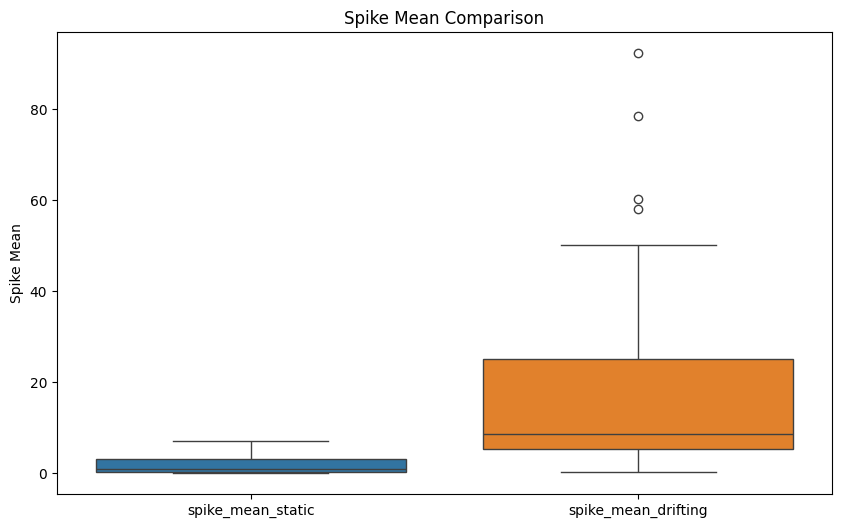

In [14]:
# Summary statistics
print(merged_spikes[['spike_mean_static', 'spike_mean_drifting']].describe())

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_spikes[['spike_mean_static', 'spike_mean_drifting']])
plt.title('Spike Mean Comparison')
plt.ylabel('Spike Mean')
plt.show()



### Hypothesis testing 

H0: there is no difference in mean number of spikes between drifting and static gratings.

In [40]:
# Shapiro-Wilk test for normality

merged_spikes['diff'] = merged_spikes['spike_mean_drifting'] - merged_spikes['spike_mean_static']

shapiro_stat, shapiro_p = stats.shapiro(merged_spikes['diff'])
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")

# we select alpha as 0.05
alpha = 0.05
if shapiro_p > alpha:
    print("Differences are normally distributed (fail to reject H0)")
else:
    print("Differences are NOT normally distributed")

Shapiro-Wilk p-value: 0.0000
Differences are NOT normally distributed


Given the differences are not normally distributed we should consider a non parametric test like Wilcoxon signed-rank test to test our null hypothesis.

In [18]:
# Paired t-test (parametric)
t_stat, t_p = stats.ttest_rel(merged_spikes['spike_mean_static'], merged_spikes['spike_mean_drifting'])
print(f"Paired t-test p-value: {t_p:.4f}")

# Wilcoxon signed-rank test (non-parametric)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(merged_spikes['spike_mean_static'], merged_spikes['spike_mean_drifting'])
print(f"Wilcoxon p-value: {wilcoxon_p:.4f}")

Paired t-test p-value: 0.0000
Wilcoxon p-value: 0.0000


We conclude that we can reject H0. There is evidence to suggest that the spike mean is different between static and drifting gratings. This result was unexpected given the results of the boxplots shown above which demonstrates spike mean is significantly higher in general for units when presented with drifting gratings.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = merged_spikes[['spike_mean_drifting', 'spike_mean_static']]
y = np.where(merged_spikes['spike_mean_drifting'] > merged_spikes['spike_mean_static'], 1, 0)  # Binary label

clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5)
print(f"Classification Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

Classification Accuracy: 1.000 ± 0.000


We see that we can easily build a simply classifier to effectively decode the type of stimulus (static vs drifting) simply from the spike_mean (spike count per presentation).

No we do the same investigation with the spike coefficient of variation (CV=std/mean) to see investigate the difference in variability between static and drifting gratings.

       spike_CV_static  spike_CV_drifting
count        60.000000          60.000000
mean          1.492445           0.808242
std           1.066668           0.410285
min           0.329193           0.250722
25%           0.691951           0.455950
50%           1.154126           0.713168
75%           2.106592           1.048522
max           4.779069           1.895985


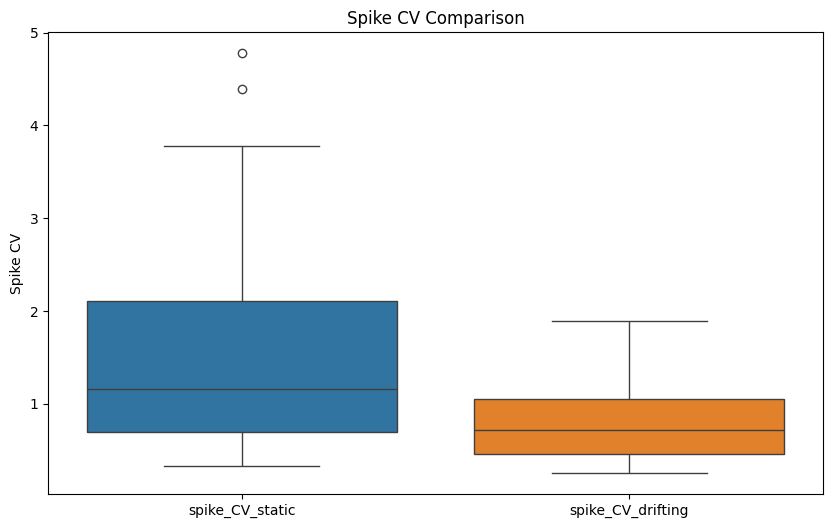

In [45]:
merged_spikes_var = merged_spikes.copy()

# Calculate the coefficient of variation (CV) for static and drifting conditions
merged_spikes_var['spike_CV_static'] = merged_spikes_var['spike_std_static'] / merged_spikes_var['spike_mean_static']
merged_spikes_var['spike_CV_drifting'] = merged_spikes_var['spike_std_drifting'] / merged_spikes_var['spike_mean_drifting']

# Summary statistics
print(merged_spikes_var[['spike_CV_static', 'spike_CV_drifting']].describe())

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_spikes_var[['spike_CV_static', 'spike_CV_drifting']])
plt.title('Spike CV Comparison')
plt.ylabel('Spike CV')
plt.show()


We see that CV is if anything higher for static gratings suggesting a higher variability in static gratings. We again verify if the pairwise differences are normally distributed.

H0: There is no difference between the CV of static and drifting spikes for overlapping units

In [46]:
# Shapiro-Wilk test for normality

merged_spikes_var['diff_CV'] = merged_spikes_var['spike_CV_static'] - merged_spikes_var['spike_CV_drifting']

shapiro_stat, shapiro_p = stats.shapiro(merged_spikes_var['diff_CV'])
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f}")

# we select alpha as 0.05
alpha = 0.05
if shapiro_p > alpha:
    print("Differences in CV are normally distributed (fail to reject H0)")
else:
    print("Differences in CV are NOT normally distributed (reject H0)")

Shapiro-Wilk p-value: 0.0000
Differences in CV are NOT normally distributed (reject H0)


In [47]:
# Paired t-test (parametric)
t_stat, t_p = stats.ttest_rel(merged_spikes_var['spike_CV_static'], merged_spikes_var['spike_CV_drifting'])
print(f"Paired t-test p-value: {t_p:.4f}")

# Wilcoxon signed-rank test (non-parametric)
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(merged_spikes_var['spike_CV_static'], merged_spikes_var['spike_CV_drifting'])
print(f"Wilcoxon p-value: {wilcoxon_p:.4f}")

Paired t-test p-value: 0.0000
Wilcoxon p-value: 0.0000


In [48]:
X = merged_spikes_var[['spike_CV_static', 'spike_CV_drifting']]
y = np.where(merged_spikes_var['spike_CV_static'] > merged_spikes_var['spike_CV_drifting'], 1, 0)  # Binary label

clf = RandomForestClassifier()
scores = cross_val_score(clf, X, y, cv=5)
print(f"Classification Accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

del merged_spikes_var #Delete this to free up space

Classification Accuracy: 0.933 ± 0.033


We conclude that in fact the Coefficient of Variation (CV) is in fact higher for static gratings than drifting gratings. This difference is also statistically significant. CV can also be used to decode the stimulus type though not quite as effectively.